In [2]:
import sys
sys.path.insert(0, "../")
import os
import time
import json
import numpy
import torch
import matplotlib
import torchaudio
import torchvision.transforms as transforms
import torchaudio
import nevergrad
import dave_models
from matplotlib import pyplot
from pytorch_lightning.utilities.seed import seed_everything
from tqdm.notebook import tqdm
from dataloaders.image_caption_dataset import ImageCaptionDataset
from speech2image.model import Speech2Image
from IPython.display import Audio

%matplotlib inline

In [13]:
model_path = "../checkpoints_speech2image/stylegan2-051221_2133/speech2image_epoch=0227.ckpt"
assert os.path.isfile(model_path), sorted(os.listdir(os.path.dirname(model_path)))[-1]

In [14]:
model = Speech2Image().cuda()
model.load_state_dict(torch.load(model_path, map_location=model.device)["state_dict"], strict=False)

INFO:root:Vocabulary size: 5000


_IncompatibleKeys(missing_keys=['aug.ada_aug_buf'], unexpected_keys=[])

In [17]:
dataset = "../data/hval.json"
model_dir = "./trained_models"
davenet_path = os.path.join(model_dir, "davenet_vgg16_MISA_1024_pretrained/")
audio_model, image_model = dave_models.DAVEnet_model_loader(os.path.join(davenet_path, "audio_model.pth"), os.path.join(davenet_path, "image_model.pth"))

In [18]:
audio_conf = {"audio_type": "audio", "use_raw_length": True}
vdataset = ImageCaptionDataset(dataset, audio_conf=audio_conf, image_conf={"center_crop": True}, normalize=False)
vdataset.audio_base_path = os.path.join("../", vdataset.audio_base_path)
vdataset.image_base_path = os.path.join("../", vdataset.image_base_path)
data_key = {x["wav"]:x for x in vdataset.data}
loader = torch.utils.data.DataLoader(vdataset, shuffle=True, num_workers=8, batch_size=1)

In [19]:
_ = model.eval()

INFO:pytorch_lightning.utilities.seed:Global seed set to 1621216052


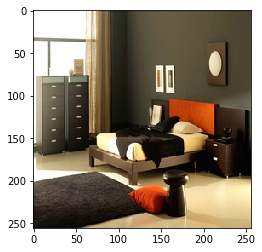

In [22]:
seed_everything(time.time())
n = numpy.random.randint(100)
for i, (image, audio, _, apath) in enumerate(loader):
    if i == n:
        break
pyplot.imshow(image[0].permute(1, 2, 0).cpu().numpy())
Audio(apath[0])

In [23]:
mel = torchaudio.transforms.MelSpectrogram(n_mels=40).cuda()

In [25]:
audio_model = audio_model.cuda()
image_model = image_model.cuda()

In [26]:
def get_imagefeatures(img):
    image_feature_map = image_model(img.unsqueeze(0)).squeeze(0)
    emb_dim = image_feature_map.size(0)
    output_H = image_feature_map.size(1)
    output_W = image_feature_map.size(2)
    return image_feature_map.view(emb_dim, output_H * output_W), (emb_dim, output_H, output_W)

def get_audiofeatures(melspec):
    audio_output = audio_model(melspec.unsqueeze(0).unsqueeze(0)).squeeze(0)
    return audio_output

def score(melspec, img):
    image_output, image_dim = get_imagefeatures(img)
    audio_output = get_audiofeatures(melspec)
    _, img_outputH, img_outputW = image_dim
    heatmap = torch.mm(audio_output.t(), image_output).squeeze()
    heatmap = heatmap.view(audio_output.size(1), img_outputH, img_outputW)
    N_t = audio_output.size(1)
    N_r = img_outputH
    N_c = img_outputW
    sisa = torch.sum(heatmap) / (N_t * N_r * N_c)
    misa = torch.sum(torch.amax(heatmap.view(N_t, N_r * N_c), dim=1))/(N_t)
    sima = torch.sum(torch.amax(heatmap, dim=1)) / (N_r * N_c)
    return misa

In [33]:
z = torch.nn.Parameter(torch.randn(1, 1, 512, device="cuda"))
opt = torch.optim.Adam([z], lr=0.01)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


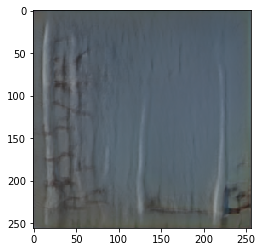

In [34]:
seed_everything(0)
x = model.enc(audio).mean(dim=1).view(1, 1, 512).cuda()
audio = audio.cuda()
n = torch.cat([z], dim=0).unbind(0)
fake_img, _ = model.G_EMA(n)
pyplot.imshow(fake_img[0].permute(1, 2, 0).detach().cpu().numpy())

In [35]:
print(score(mel(audio)[0], fake_img[0]))

tensor(0.7669, device='cuda:0', grad_fn=<DivBackward0>)


In [36]:
n_steps = 100
l = tqdm(range(n_steps))
for i in l:
    opt.zero_grad()
    seed_everything(0)
    n = torch.cat([x, z], dim=0).unbind(0)
    fake_img, _ = model.G_EMA(n)
    s = -score(mel(audio)[0], fake_img[0])
    s.backward(retain_graph=i != (n_steps - 1))
    l.set_postfix(l=s.item())
    opt.step()
    if i % 100 == 0:
        fimg = fake_img[0].permute(1, 2, 0).detach().cpu().numpy()
        pyplot.imsave("test%d.png" % i, (fimg - fimg.min())/(fimg.max() - fimg.min()))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.seed:Global seed set to

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


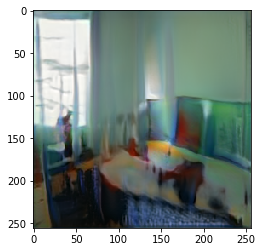

In [37]:
seed_everything(0)
n = torch.cat([x, z], dim=0).unbind(0)
f_img, _ = model.G_EMA(n)
pyplot.imshow(f_img[0].permute(1, 2, 0).detach().cpu().numpy())

In [38]:
print(score(mel(audio)[0], f_img[0]))

tensor(3.2205, device='cuda:0', grad_fn=<DivBackward0>)
